In [1]:
import numpy as np
import time

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

classifier_model ="https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/classification/4" 

IMAGE_SHAPE = (224, 224)

In [2]:
classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE+(3,))
])

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper
grace_hopper = np.array(grace_hopper)/255.0



In [3]:

result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape



(1, 1001)

In [4]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class



653

In [5]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())


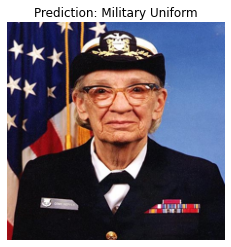

In [6]:

plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

In [49]:
data_root = 'C:\\Users\\omxie\\.keras\\datasets\\big_dataset'

In [50]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)

Found 2000 images belonging to 3 classes.


In [51]:
for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 3)


In [52]:
result_batch = classifier.predict(image_batch)
result_batch.shape

(32, 1001)

In [53]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['envelope', 'porcupine', 'dough', 'tick', 'toilet seat',
       'nematode', 'tick', 'handkerchief', 'harvestman', 'tick', 'dough',
       'syringe', 'tick', 'tick', 'envelope', 'nail', 'tick', 'tick',
       'tick', 'paintbrush', 'chow', 'tick', 'Angora', 'tick', 'tick',
       'rubber eraser', 'tick', 'sea urchin', 'tick', 'Petri dish',
       'tick', 'nematode'], dtype='<U30')

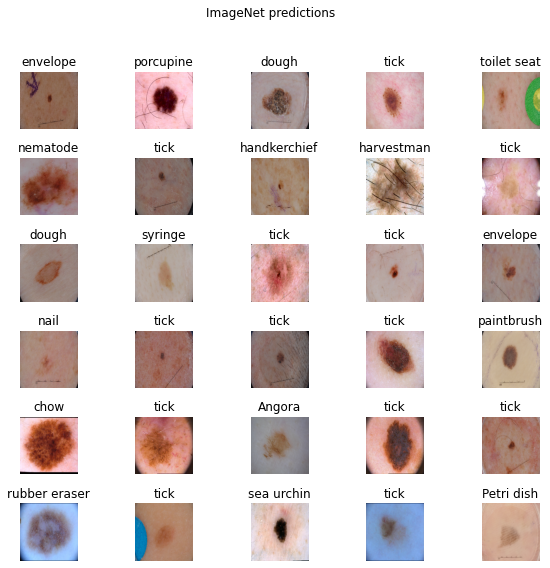

In [54]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

In [55]:
feature_extractor_model = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4" 

In [56]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [57]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


In [58]:
model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(image_data.num_classes)
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


In [59]:
predictions = model(image_batch)

In [60]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

In [61]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

In [68]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit(image_data, epochs=2,
                    steps_per_epoch=steps_per_epoch,
                    callbacks=[batch_stats_callback])

Epoch 1/5
63/63 [==============================] - 245s 4s/step - loss: 0.7685 - acc: 0.5938
Epoch 2/5
63/63 [==============================] - 282s 4s/step - loss: 0.5069 - acc: 0.7812
Epoch 3/5
63/63 [==============================] - 287s 5s/step - loss: 0.3627 - acc: 0.8750
Epoch 4/5
63/63 [==============================] - 293s 5s/step - loss: 0.6332 - acc: 0.7500
Epoch 5/5
63/63 [==============================] - 284s 5s/step - loss: 0.4498 - acc: 0.7812


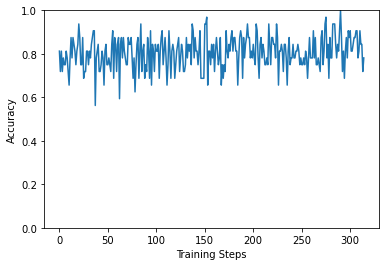

In [69]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

In [70]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Melanoma', 'Nevus', 'Seborrheic_Keratosis'], dtype='<U20')

In [71]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

In [72]:
label_id = np.argmax(label_batch, axis=-1)

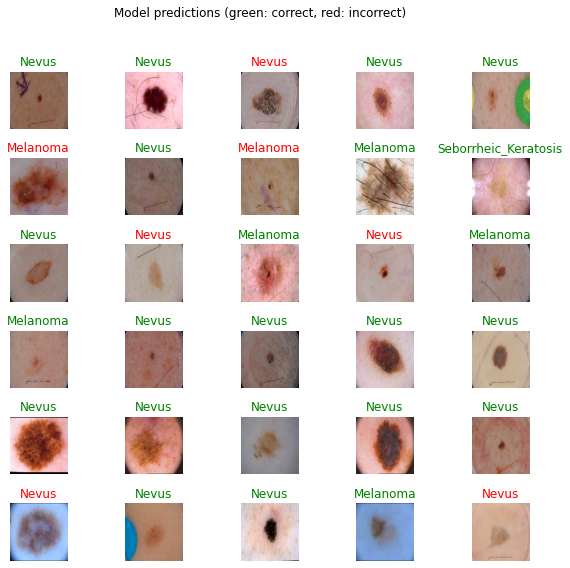

In [73]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

In [48]:
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
model.save(export_path)

export_path

INFO:tensorflow:Assets written to: /tmp/saved_models/1601193019\assets


INFO:tensorflow:Assets written to: /tmp/saved_models/1601193019\assets


'/tmp/saved_models/1601193019'